In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv('UNSW_NB15_training-set.csv')

In [3]:
df.dtypes

id                     int64
dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm             int64
ct_src_dport_l

In [4]:
from sklearn.preprocessing import LabelEncoder

# Label encoding for 'proto', 'service', 'state'
label_encoder = LabelEncoder()
for col in ['proto', 'service', 'state']:
    df[col] = label_encoder.fit_transform(df[col])

# One-hot encoding for 'attack_cat'
attack_cat_dummies = pd.get_dummies(df['attack_cat'], prefix='attack_cat')
df = pd.concat([df, attack_cat_dummies], axis=1)

# Optional: Ensure integer type for dummy variables
dummy_columns = attack_cat_dummies.columns
df[dummy_columns] = df[dummy_columns].astype(int)

# Drop the original 'attack_cat' column if no longer needed
df.drop(columns=['attack_cat'], inplace=True)

# Display the DataFrame
df


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,attack_cat_Analysis,attack_cat_Backdoor,attack_cat_DoS,attack_cat_Exploits,attack_cat_Fuzzers,attack_cat_Generic,attack_cat_Normal,attack_cat_Reconnaissance,attack_cat_Shellcode,attack_cat_Worms
0,1,0.121478,113,0,2,6,4,258,172,74.087490,...,0,0,0,0,0,0,1,0,0,0
1,2,0.649902,113,0,2,14,38,734,42014,78.473372,...,0,0,0,0,0,0,1,0,0,0
2,3,1.623129,113,0,2,8,16,364,13186,14.170161,...,0,0,0,0,0,0,1,0,0,0
3,4,1.681642,113,3,2,12,12,628,770,13.677108,...,0,0,0,0,0,0,1,0,0,0
4,5,0.449454,113,0,2,10,6,534,268,33.373826,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,119,2,3,2,0,114,0,111111.107200,...,0,0,0,0,0,1,0,0,0,0
175337,175338,0.505762,113,0,2,10,8,620,354,33.612649,...,0,0,0,0,0,0,0,0,1,0
175338,175339,0.000009,119,2,3,2,0,114,0,111111.107200,...,0,0,0,0,0,1,0,0,0,0
175339,175340,0.000009,119,2,3,2,0,114,0,111111.107200,...,0,0,0,0,0,1,0,0,0,0


In [5]:
corr = df.corr()
corr.style.background_gradient(cmap = "coolwarm")

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,attack_cat_Analysis,attack_cat_Backdoor,attack_cat_DoS,attack_cat_Exploits,attack_cat_Fuzzers,attack_cat_Generic,attack_cat_Normal,attack_cat_Reconnaissance,attack_cat_Shellcode,attack_cat_Worms
id,1.000000,0.006587,0.013943,0.038238,0.518446,-0.068827,-0.126316,0.001104,-0.080283,0.364575,0.615508,-0.049604,0.143649,-0.356902,-0.018451,-0.099755,0.027197,-0.027327,-0.019626,-0.081799,-0.416529,-0.326110,-0.326044,-0.412318,0.001216,-0.004703,0.007422,-0.083356,-0.361818,-0.019404,-0.020558,0.478979,0.617467,0.467591,0.536544,0.601158,0.539093,-0.037636,-0.037636,-0.028287,0.425396,0.480899,0.033142,0.727173,0.006772,0.011382,0.049873,0.067401,0.041116,0.652849,-0.727173,0.043675,0.013030,0.004023
dur,0.006587,1.000000,-0.124502,-0.008234,0.103443,0.254559,0.181182,0.199731,0.144134,-0.120966,0.012196,0.044159,-0.081749,-0.050603,0.198597,0.142963,0.080055,0.152142,0.144413,0.157443,0.022047,0.013183,0.014724,0.017527,0.053125,0.051093,0.049332,0.090028,0.025336,0.002071,0.078915,-0.113709,0.186293,-0.086300,-0.094091,-0.093923,-0.101760,0.020641,0.020641,0.024743,-0.080871,-0.115336,0.035370,0.036175,0.007332,0.020111,0.051440,0.067300,0.078692,-0.108910,-0.036175,-0.011651,-0.012351,0.000293
proto,0.013943,-0.124502,1.000000,0.170032,-0.172441,0.013469,0.026439,0.005920,0.015812,0.013924,0.049944,0.113184,0.004759,0.046375,0.011392,0.020002,-0.562789,-0.052417,0.016011,0.019388,0.138967,0.108571,0.108630,0.137605,0.079193,0.073528,0.076362,0.042157,0.077296,0.020709,0.006005,0.203057,-0.162433,0.191101,0.174965,0.165796,0.175708,0.018003,0.018003,0.028809,0.168121,0.198594,-0.585941,0.020267,-0.054173,-0.067810,-0.175389,-0.119383,0.047967,0.221514,-0.020267,0.016734,0.023248,0.004979
service,0.038238,-0.008234,0.170032,1.000000,-0.144978,0.114403,0.077338,0.105188,0.035492,-0.141709,-0.295302,0.262970,-0.166339,-0.099581,0.114522,0.051495,-0.089971,-0.020190,-0.011469,0.090262,0.292887,0.237103,0.237723,0.300035,0.140239,0.110995,0.155811,0.224861,0.145641,0.191839,0.056951,-0.058269,-0.205943,0.047685,0.038347,0.051106,-0.006774,0.071051,0.071051,0.266206,0.028599,-0.048011,-0.088847,0.035052,-0.009176,-0.058074,-0.097600,0.229139,-0.186089,0.092486,-0.035052,-0.086103,-0.056638,0.032681
state,0.518446,0.103443,-0.172441,-0.144978,1.000000,-0.078701,-0.098268,-0.049300,-0.059759,0.432307,0.584697,-0.375533,0.292570,-0.150501,-0.060125,-0.071056,0.095492,-0.076235,-0.045441,-0.064747,-0.367493,-0.314361,-0.313922,-0.397710,-0.278469,-0.261882,-0.264946,-0.070796,-0.256392,-0.056128,-0.025541,0.385515,0.759825,0.328748,0.372309,0.408662,0.429906,-0.051970,-0.051970,-0.078856,0.323019,0.387446,0.094198,0.497685,0.045893,0.050618,0.135852,0.014971,0.012058,0.396001,-0.497685,0.045764,0.014236,-0.008491
spkts,-0.068827,0.254559,0.013469,0.114403,-0.078701,1.000000,0.390067,0.963791,0.206609,-0.076358,-0.102723,0.068246,-0.051646,0.075897,0.971069,0.207798,-0.017587,-0.001678,-0.000384,0.017096,0.131813,0.107410,0.102161,0.133102,0.039187,0.035507,0.038725,0.216592,0.150237,0.008834,0.087217,-0.069127,-0.086170,-0.060194,-0.068373,-0.072484,-0.077553,0.009951,0.009951,0.006084,-0.061584,-0.069598,-0.017770,-0.052178,-0.011132,-0.009331,0.004459,0.044003,-0.014603,-0.070795,0.052178,-0.024403,-0.008463,-0.000317
dpkts,-0.126316,0.181182,0.026439,0.077338,-0.098268,0.390067,1.000000,0.188476,0.971907,-0.098202,-0.192580,0.053861,-0.066710,0.139145,0.204883,0.978636,-0.022160,-0.006514,0.000229,0.054371,0.183703,0.144119,0.142667,0.185555,0.020915,0.015936,0.023899,0.014697,0.441445,0.029042,0.442194,-0.079095,-0.150023,-0.071909,-0.086695,-0.094267,-0.094085,0.013491

In [6]:
from collections import Counter

#filtered_df = df[df['label'] == 1]

xs = df.drop(columns = ['id','label','attack_cat_Normal', 'attack_cat_Analysis','attack_cat_Backdoor', 'attack_cat_DoS', 'attack_cat_Exploits', 
      'attack_cat_Fuzzers', 'attack_cat_Generic',
      'attack_cat_Reconnaissance', 'attack_cat_Shellcode', 'attack_cat_Worms'])

ys = df[['attack_cat_Analysis','attack_cat_Backdoor', 'attack_cat_DoS', 'attack_cat_Exploits', 
      'attack_cat_Fuzzers', 'attack_cat_Generic',  'attack_cat_Normal',
      'attack_cat_Reconnaissance', 'attack_cat_Shellcode', 'attack_cat_Worms']]

X_train = xs
y_train = ys

print(xs.shape)
print(ys.shape)

# Ensure ys is converted to labels
class_labels = ys.idxmax(axis=1)  # Converts one-hot encoded columns to class labels
counter = Counter(class_labels)

# Display the distribution
total = len(class_labels)
for cls, count in counter.items():
    percentage = count / total * 100
    print(f'Class = {cls}, n = {count} ({percentage:.3f}%)')

(175341, 42)
(175341, 10)
Class = attack_cat_Normal, n = 56000 (31.938%)
Class = attack_cat_Backdoor, n = 1746 (0.996%)
Class = attack_cat_Analysis, n = 2000 (1.141%)
Class = attack_cat_Fuzzers, n = 18184 (10.371%)
Class = attack_cat_Shellcode, n = 1133 (0.646%)
Class = attack_cat_Reconnaissance, n = 10491 (5.983%)
Class = attack_cat_Exploits, n = 33393 (19.045%)
Class = attack_cat_DoS, n = 12264 (6.994%)
Class = attack_cat_Worms, n = 130 (0.074%)
Class = attack_cat_Generic, n = 40000 (22.813%)


In [7]:
xs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                175341 non-null  float64
 1   proto              175341 non-null  int32  
 2   service            175341 non-null  int32  
 3   state              175341 non-null  int32  
 4   spkts              175341 non-null  int64  
 5   dpkts              175341 non-null  int64  
 6   sbytes             175341 non-null  int64  
 7   dbytes             175341 non-null  int64  
 8   rate               175341 non-null  float64
 9   sttl               175341 non-null  int64  
 10  dttl               175341 non-null  int64  
 11  sload              175341 non-null  float64
 12  dload              175341 non-null  float64
 13  sloss              175341 non-null  int64  
 14  dloss              175341 non-null  int64  
 15  sinpkt             175341 non-null  float64
 16  di

In [8]:
ys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   attack_cat_Analysis        175341 non-null  int32
 1   attack_cat_Backdoor        175341 non-null  int32
 2   attack_cat_DoS             175341 non-null  int32
 3   attack_cat_Exploits        175341 non-null  int32
 4   attack_cat_Fuzzers         175341 non-null  int32
 5   attack_cat_Generic         175341 non-null  int32
 6   attack_cat_Normal          175341 non-null  int32
 7   attack_cat_Reconnaissance  175341 non-null  int32
 8   attack_cat_Shellcode       175341 non-null  int32
 9   attack_cat_Worms           175341 non-null  int32
dtypes: int32(10)
memory usage: 6.7 MB


In [9]:
X_train = X_train.values
y_train = y_train.values

smote = SMOTE()

X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)

print("X after sampling: ", X_train_sampled.shape)
print("y after sampling: ", y_train_sampled.shape)

X after sampling:  (560000, 42)
y after sampling:  (560000, 10)


In [10]:
df_2 = pd.read_csv('UNSW_NB15_testing-set.csv')

for col in ['proto', 'service', 'state']:
    df_2[col] = label_encoder.fit_transform(df_2[col])
    
# One-hot encoding for 'attack_cat'
attack_cat_dummies = pd.get_dummies(df_2['attack_cat'], prefix='attack_cat')
df_2 = pd.concat([df_2, attack_cat_dummies], axis=1)

# Optional: Ensure integer type for dummy variables
dummy_columns = attack_cat_dummies.columns
df_2[dummy_columns] = df_2[dummy_columns].astype(int)

# Drop the original 'attack_cat' column if no longer needed
df_2.drop(columns=['attack_cat'], inplace=True)

#filtered_df_2 = df_2[df_2['label'] == 1]

test_x = df_2.drop(columns = ['id','label','attack_cat_Normal', 'attack_cat_Analysis','attack_cat_Backdoor', 'attack_cat_DoS', 'attack_cat_Exploits', 
      'attack_cat_Fuzzers', 'attack_cat_Generic',
      'attack_cat_Reconnaissance', 'attack_cat_Shellcode', 'attack_cat_Worms'])

test_y = df_2[['attack_cat_Analysis','attack_cat_Backdoor', 'attack_cat_DoS', 'attack_cat_Exploits', 
      'attack_cat_Fuzzers', 'attack_cat_Generic',  'attack_cat_Normal',
      'attack_cat_Reconnaissance', 'attack_cat_Shellcode', 'attack_cat_Worms']]


X_test = test_x.values
y_test = test_y.values

In [11]:
scaler_1 = StandardScaler()
scaler_2 = StandardScaler()

# Fit on training data and transform all datasets
X_train_scaled = scaler_1.fit_transform(X_train_sampled)
X_test_scaled = scaler_1.transform(X_test)

#y_train_scaled = scaler_2.fit_transform(y_train)
#y_val_scaled = scaler_2.transform(y_val)
#y_test_scaled = scaler_2.transform(y_test)


In [12]:
import torch 

# Convert numpy arrays to PyTorch tensors

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sampled, dtype=torch.float32)



X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [13]:
y_train_tensor.shape

torch.Size([560000, 10])

In [14]:
ys.shape

(175341, 10)

In [15]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim


# Creating Tensor datasets

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
'''
class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        # Compute the queries, keys, and values
        Q = self.query(x)  # (batch_size, seq_len, input_dim)
        K = self.key(x)    # (batch_size, seq_len, input_dim)
        V = self.value(x)  # (batch_size, seq_len, input_dim)

        # Scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(Q.size(-1), dtype=torch.float32))
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Apply the attention weights to the values
        attended_values = torch.matmul(attention_weights, V)
        
        return attended_values
'''

class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads=8, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.scale = (self.head_dim ** -0.5)
        
        self.qkv = nn.Linear(input_dim, input_dim * 3)
        self.fc_out = nn.Linear(input_dim, input_dim)
        
        self.norm = nn.LayerNorm(input_dim)
        self.attention_dropout = nn.Dropout(dropout)
        self.projection_dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x = self.norm(x)  # Apply layer normalization
        
        # Single projection for Q, K, V
        qkv = self.qkv(x)  # (batch_size, seq_len, 3 * input_dim)
        Q, K, V = qkv.chunk(3, dim=-1)  # Split into Q, K, V
        
        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # Scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attention_scores = attention_scores - attention_scores.max(dim=-1, keepdim=True).values  # Stabilize
        attention_weights = self.attention_dropout(F.softmax(attention_scores, dim=-1))
        attended_values = torch.matmul(attention_weights, V)
        
        # Concatenate heads and pass through final linear layer
        attended_values = attended_values.permute(0, 2, 1, 3).reshape(batch_size, seq_len, -1)
        out = self.projection_dropout(self.fc_out(attended_values))
        
        # Add residual connection
        return x + out


class MultiLabelCNNWithAttention2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiLabelCNNWithAttention2, self).__init__()

        # Define layers
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            nn.BatchNorm1d(32)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            nn.BatchNorm1d(64)
        )
        self.layer3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            nn.BatchNorm1d(128)
        )
        self.layer4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(256)
        )

        self.attention = MultiHeadAttention(256)  # Attention layer to apply after conv layers
        
        self.dropout = nn.Dropout(p=0.4)

        # Calculate output size for the fully connected layer after conv layers
        fc_input_dim = 256 * (input_dim//8)  # Hardcode the correct dimension based on the output shape

        self.fc1 = nn.Linear(fc_input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for Conv1d input (batch, channels, length)
        
        # Apply conv layers with batch normalization and pooling
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.layer4(x)

        # Apply attention after the last convolution layer
        x = x.transpose(1, 2)  # (batch_size, seq_len, feature_dim)
        x = self.attention(x)
        x = x.transpose(1, 2)  # Transpose back to (batch_size, feature_dim, seq_len)

        # Flatten the tensor using reshape instead of view
        x = x.reshape(x.size(0), -1)

        # Dropout and fully connected layers
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return self.sigmoid(x)


Running on:  cuda
Epoch [1/30], Train Loss: 0.1893, Train Acc: 0.9274, Test Loss: 0.1960, Test Acc: 0.9294
Epoch [2/30], Train Loss: 0.1552, Train Acc: 0.9392, Test Loss: 0.1857, Test Acc: 0.9272
Epoch [3/30], Train Loss: 0.1465, Train Acc: 0.9426, Test Loss: 0.2038, Test Acc: 0.9247
Epoch [4/30], Train Loss: 0.1423, Train Acc: 0.9444, Test Loss: 0.2071, Test Acc: 0.9239
Epoch [5/30], Train Loss: 0.1391, Train Acc: 0.9456, Test Loss: 0.1952, Test Acc: 0.9255
Epoch [6/30], Train Loss: 0.1372, Train Acc: 0.9464, Test Loss: 0.1732, Test Acc: 0.9362
Epoch [7/30], Train Loss: 0.1357, Train Acc: 0.9470, Test Loss: 0.1632, Test Acc: 0.9365
Epoch [8/30], Train Loss: 0.1347, Train Acc: 0.9474, Test Loss: 0.1600, Test Acc: 0.9382
Epoch [9/30], Train Loss: 0.1339, Train Acc: 0.9476, Test Loss: 0.1785, Test Acc: 0.9317
Epoch [10/30], Train Loss: 0.1332, Train Acc: 0.9478, Test Loss: 0.1750, Test Acc: 0.9323
Epoch [11/30], Train Loss: 0.1327, Train Acc: 0.9481, Test Loss: 0.1845, Test Acc: 0.9309
E

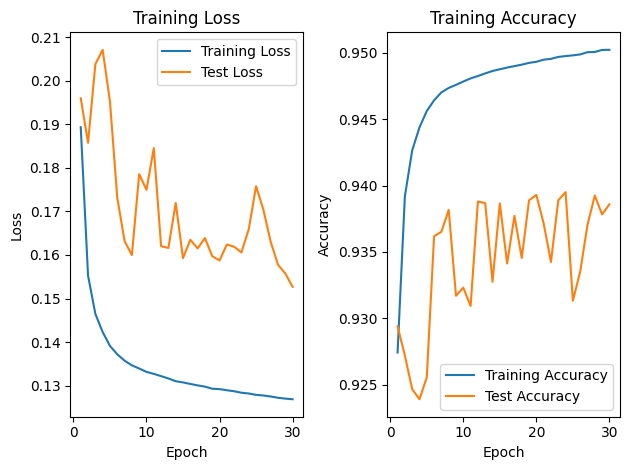

In [17]:
import torch.optim as optim

# Parameters
batch_size = 48
input_dim = X_train.shape[1]  # Number of features
output_dim = y_train.shape[1]  # Number of target classes
learning_rate = 0.0001

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)
#val_loader = DataLoader(dataset=val_dataset ,batch_size = batch_size,  shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)

# Specify the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

print("Running on: ", device)

# Initialize the model and move it to the device
model =  MultiLabelCNNWithAttention2(input_dim, output_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Using Binary Cross Entropy Loss for Multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Accuracy calculation function
def calculate_accuracy(y_pred, y_true):
    # Apply threshold to predictions
    y_pred = (y_pred > 0.5).float()
    # Match predictions with true labels
    correct = (y_pred == y_true).float().sum()
    accuracy = correct / y_true.numel()  # Total number of elements in y_true
    return accuracy.item()


# Training loop Validation and Test loop
train_losses = []
#valid_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []


num_epochs = 30
for epoch in range(num_epochs):
    train_loss = 0
#    valid_loss = 0
    test_loss = 0

    train_accuracy = 0
    test_accuracy = 0

    
    model.train()  
    for X_train, y_train in train_loader:    
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        train_predictions = model(X_train)
    
    
        loss = criterion(train_predictions, y_train).to(device)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_train.size(0)

      # Calculate accuracy
        train_accuracy += calculate_accuracy(train_predictions, y_train) * X_train.size(0)
        
#        model.eval()       
#    with torch.no_grad():
#        for X_val, y_val in val_loader:
#            X_val, y_val = X_val.to(device), y_val.to(device)  # Move data to GPU
#            val_predictions = model(X_val)
#            loss = criterion(val_predictions, y_val).to(device)
#            valid_loss += loss.item() * X_val.size(0)
            
    model.eval()
    with torch.no_grad():
        for X_test, y_test in test_loader:            
            X_test, y_test = X_test.to(device), y_test.to(device)  # Move data to GPU
            test_predictions = model(X_test)
            loss = criterion(test_predictions, y_test).to(device)
            test_loss += loss.item() * X_test.size(0)
            # Calculate accuracy
            test_accuracy += calculate_accuracy(test_predictions, y_test) * X_test.size(0)
    
    
    # Calculate average loss per sample for the epoch
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
#    valid_loss /= len(val_loader.dataset)
    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)


    
    if (epoch+1) % 1 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')
    
    # Append losses to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
#    valid_losses.append(valid_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


# Evaluation
model.eval()
with torch.no_grad():
    train_loss = 0.0
    train_accuracy = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Loss calculation
        train_loss += criterion(outputs, labels).item() * inputs.size(0)

        # Predictions and Accuracy
 #       _, predictions = torch.max(outputs, dim=1)  # Get predicted class
 #       train_accuracy += (predictions == labels).sum().item()  # Count correct predictions

    # Normalize by the total number of samples
    train_loss /= len(train_loader.dataset)
  #  train_accuracy /= len(train_loader.dataset)

    print(f'Train Loss: {train_loss:.4f}')
  #  print(f'Train Accuracy: {train_accuracy:.4f}')


#model.eval()  
#with torch.no_grad():
#    val_loss = 0
#    for inputs, labels in val_loader:
#        outputs = model(inputs)
#        val_loss += criterion(outputs, labels).item() * X_val.size(0)
#    val_loss /= len(val_loader.dataset)
#    print(f'Validation Loss: {val_loss:.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_loss = 0.0
    test_accuracy = 0.0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Loss calculation
        test_loss += criterion(outputs, labels).item() * inputs.size(0)

        # Predictions and Accuracy
        #_, predictions = torch.max(outputs, dim=1)  # Get predicted class
        #test_accuracy += (predictions == labels).sum().item()  # Count correct predictions

    # Normalize by the total number of samples
    test_loss /= len(test_loader.dataset)
#    test_accuracy /= len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f}')
  #  print(f'Test Accuracy: {test_accuracy:.4f}')

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
layer1.0.weight 	 torch.Size([32, 1, 5])
layer1.0.bias 	 torch.Size([32])
layer1.3.weight 	 torch.Size([32])
layer1.3.bias 	 torch.Size([32])
layer1.3.running_mean 	 torch.Size([32])
layer1.3.running_var 	 torch.Size([32])
layer1.3.num_batches_tracked 	 torch.Size([])
layer2.0.weight 	 torch.Size([64, 32, 5])
layer2.0.bias 	 torch.Size([64])
layer2.3.weight 	 torch.Size([64])
layer2.3.bias 	 torch.Size([64])
layer2.3.running_mean 	 torch.Size([64])
layer2.3.running_var 	 torch.Size([64])
layer2.3.num_batches_tracked 	 torch.Size([])
layer3.0.weight 	 torch.Size([128, 64, 5])
layer3.0.bias 	 torch.Size([128])
layer3.3.weight 	 torch.Size([128])
layer3.3.bias 	 torch.Size([128])
layer3.3.running_mean 	 torch.Size([128])
layer3.3.running_var 	 torch.Size([128])
layer3.3.num_batches_tracked 	 torch.Size([])
layer4.0.weight 	 torch.Size([256, 128, 5])
layer4.0.bias 	 torch.Size([256])
layer4.2.weight 	 torch.Size([256])
layer4.2.bias 	 torch.Size([256])
layer4.2.running_

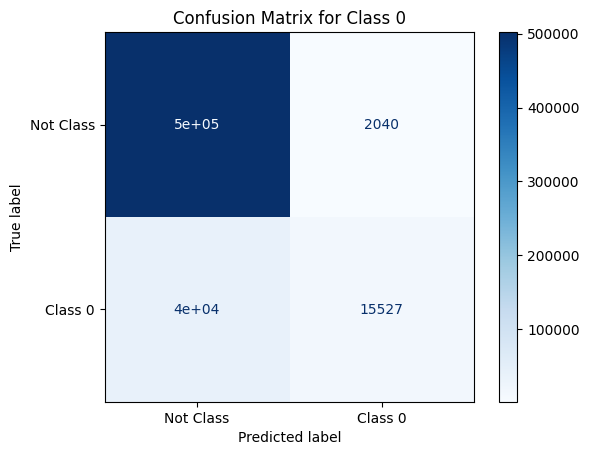

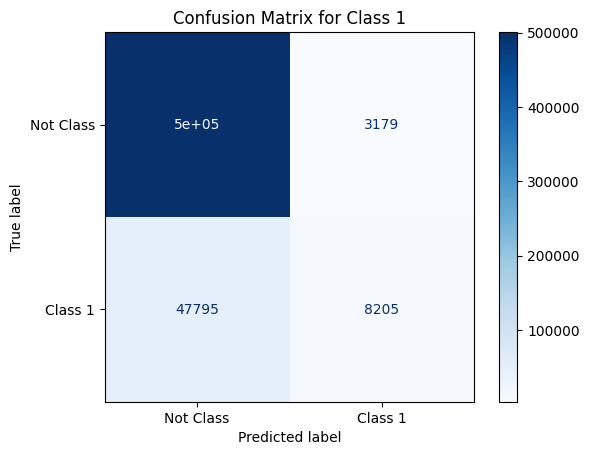

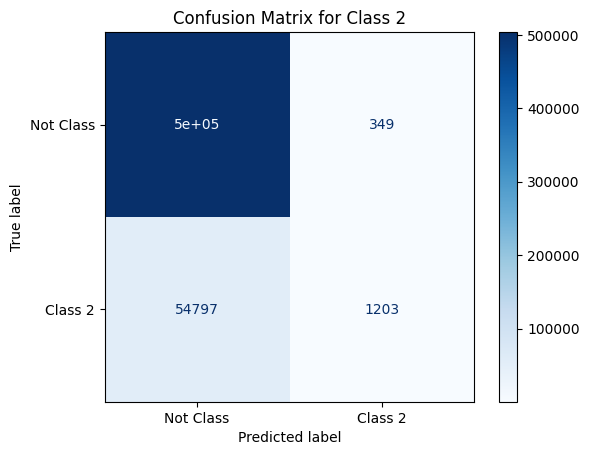

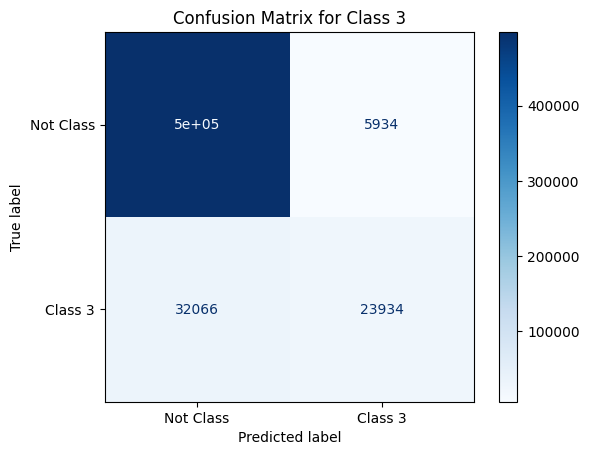

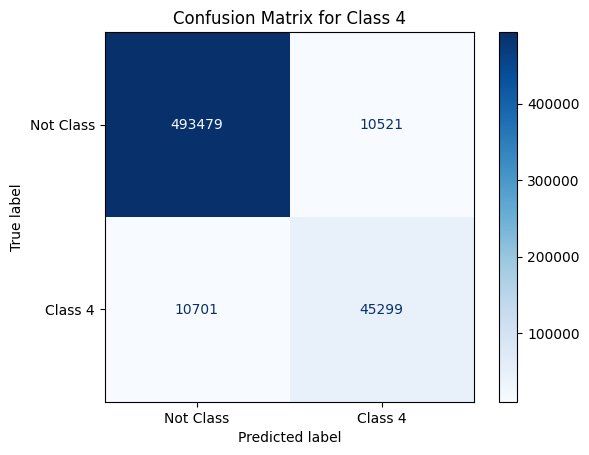

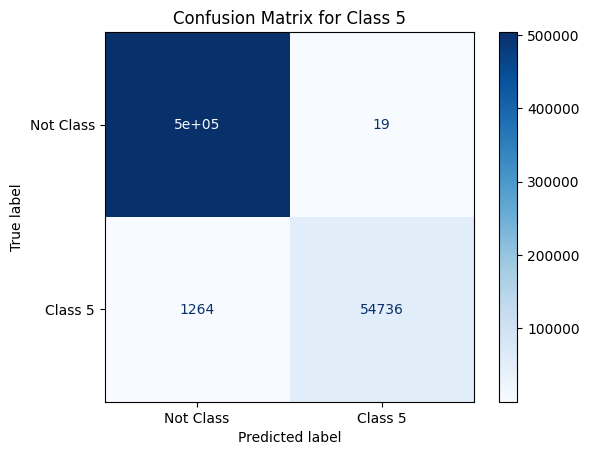

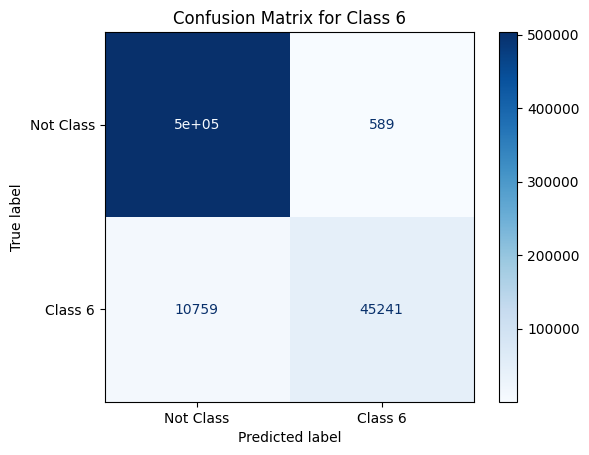

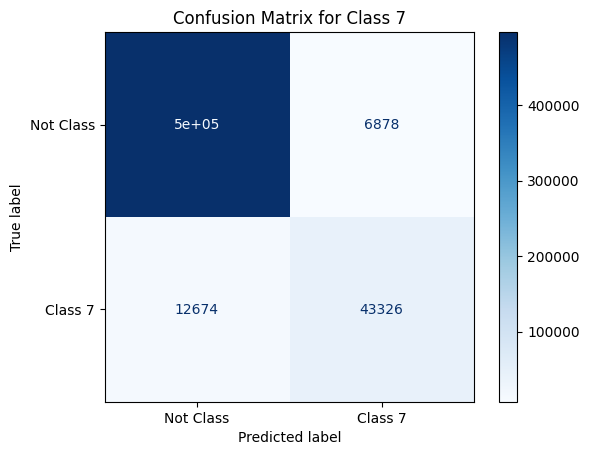

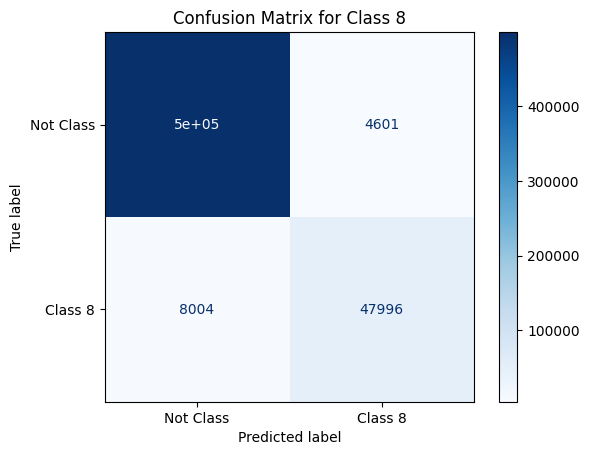

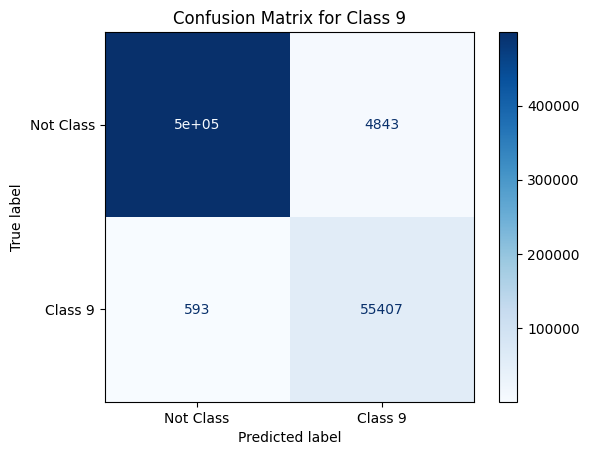

Overall Accuracy: 0.9539
Precision: 0.9520
Recall: 0.9539
F1 Score: 0.9499


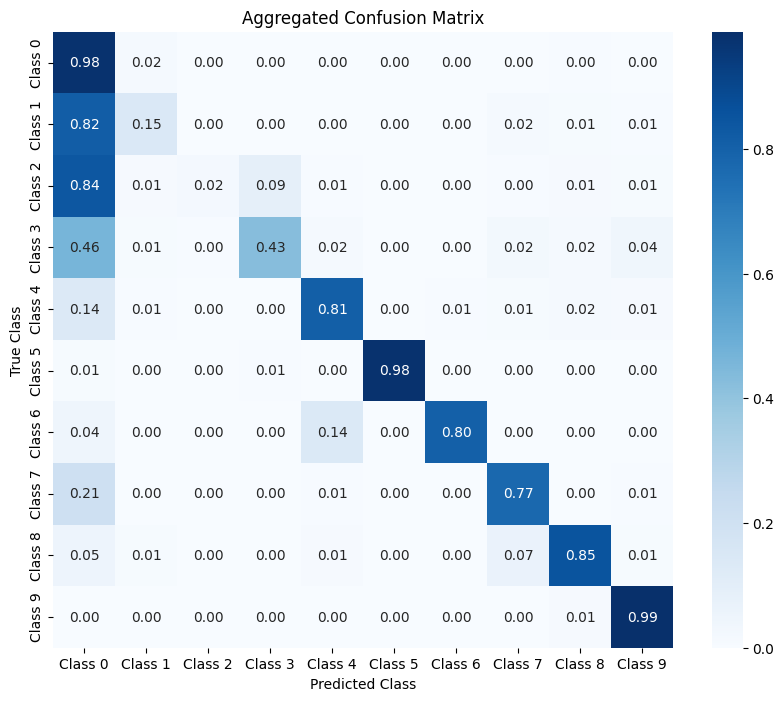

In [19]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Evaluation phase
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Apply threshold (predictions > 0.5 = 1, else 0)
        preds = (outputs > 0.5).int()

        # Append predictions and true labels to lists
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Confusion matrices for all classes
conf_matrices = multilabel_confusion_matrix(all_labels, all_preds)

# Plot each confusion matrix
for i, cm in enumerate(conf_matrices):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Class", f"Class {i}"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for Class {i}')
    plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Flatten the predictions and labels to compute overall metrics
flat_preds = all_preds.ravel()
flat_labels = all_labels.ravel()

# Calculate metrics
accuracy = accuracy_score(flat_labels, flat_preds)
precision = precision_score(flat_labels, flat_preds, average='weighted', zero_division=1)
recall = recall_score(flat_labels, flat_preds, average='weighted', zero_division=1)
f1 = f1_score(flat_labels, flat_preds, average='weighted', zero_division=1)

# Print metrics
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Summarize all predictions and labels across all classes
# True class is a row, predicted class is a column
cm = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))

# Normalize confusion matrix by true labels for better visualization
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[f"Class {i}" for i in range(cm.shape[1])], 
            yticklabels=[f"Class {i}" for i in range(cm.shape[0])])
plt.title("Aggregated Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()


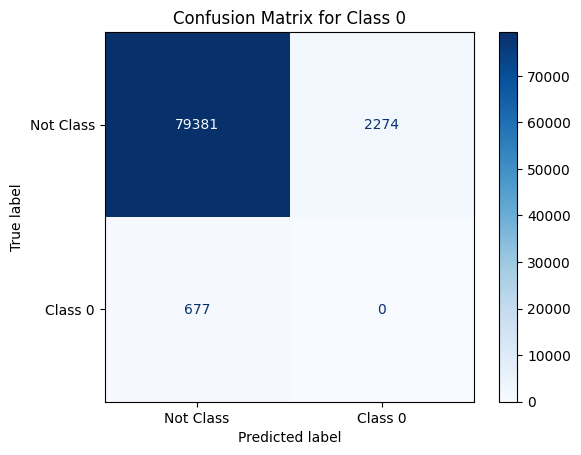

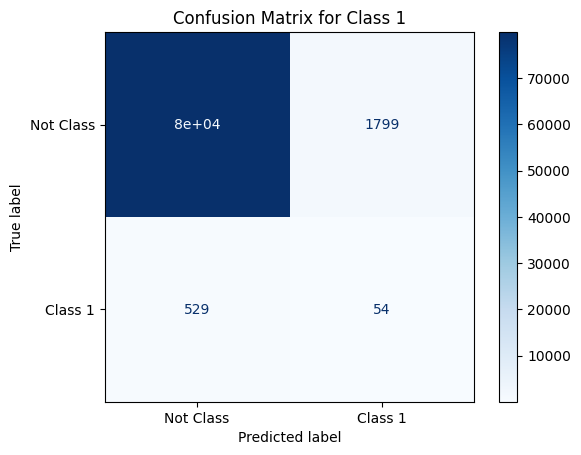

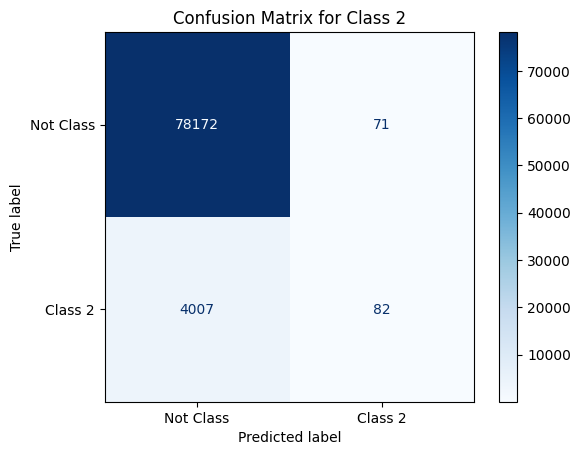

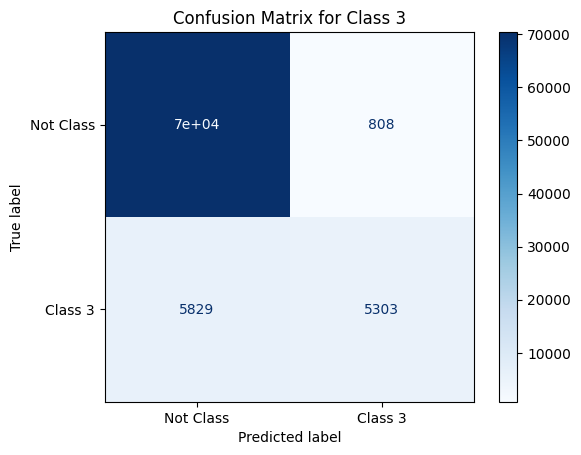

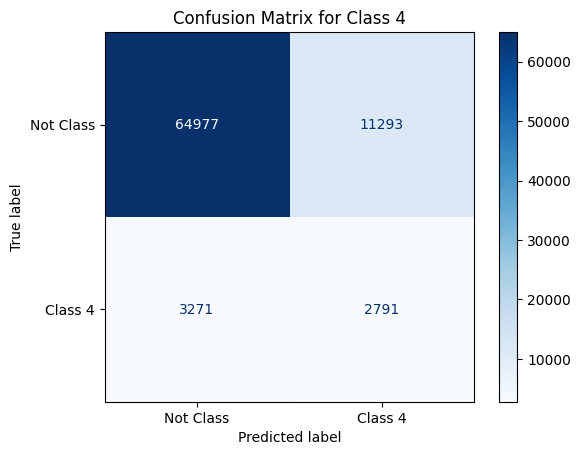

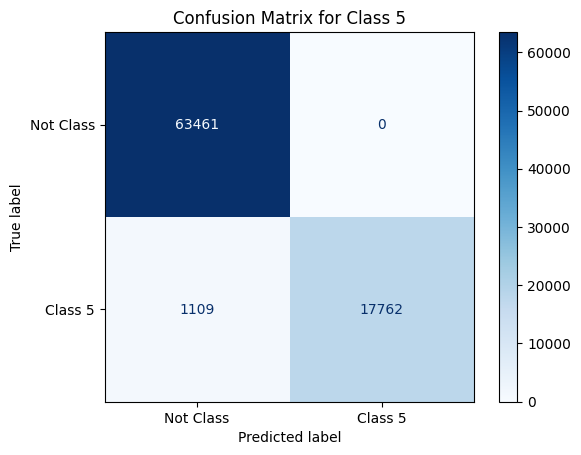

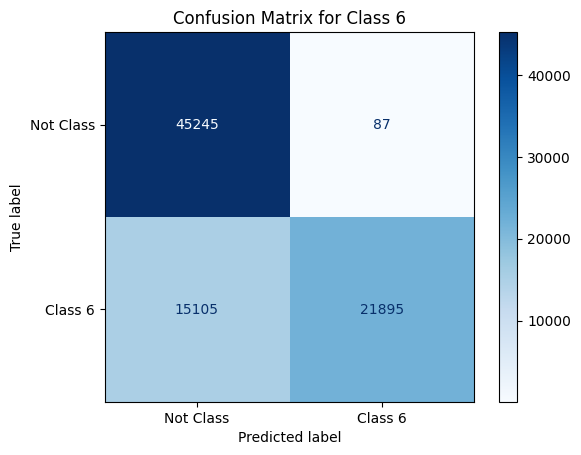

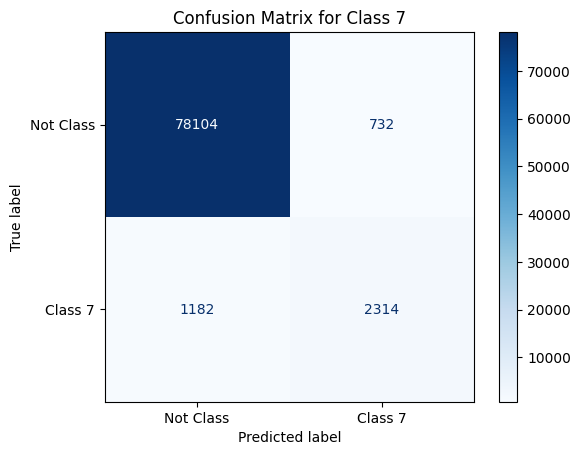

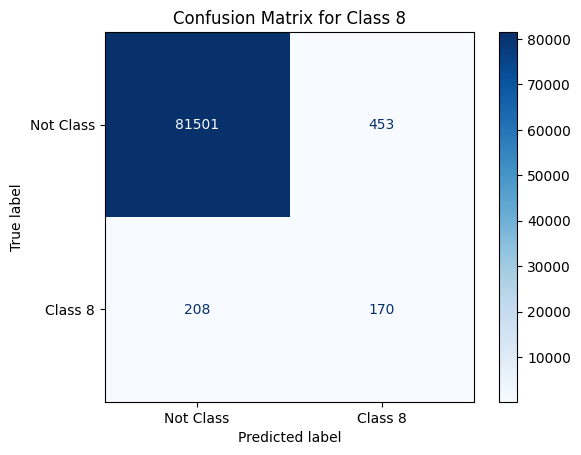

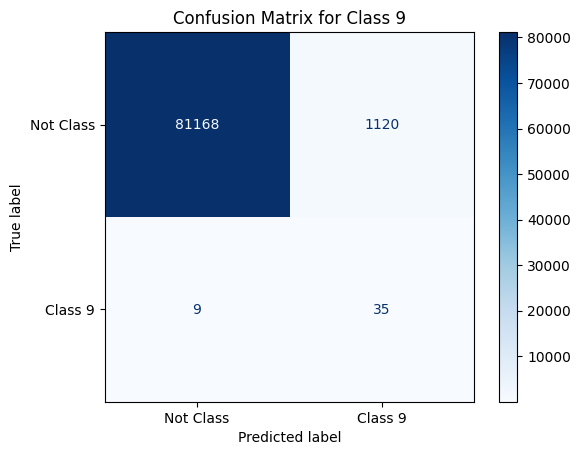

Overall Accuracy: 0.9386
Precision: 0.9349
Recall: 0.9386
F1 Score: 0.9362


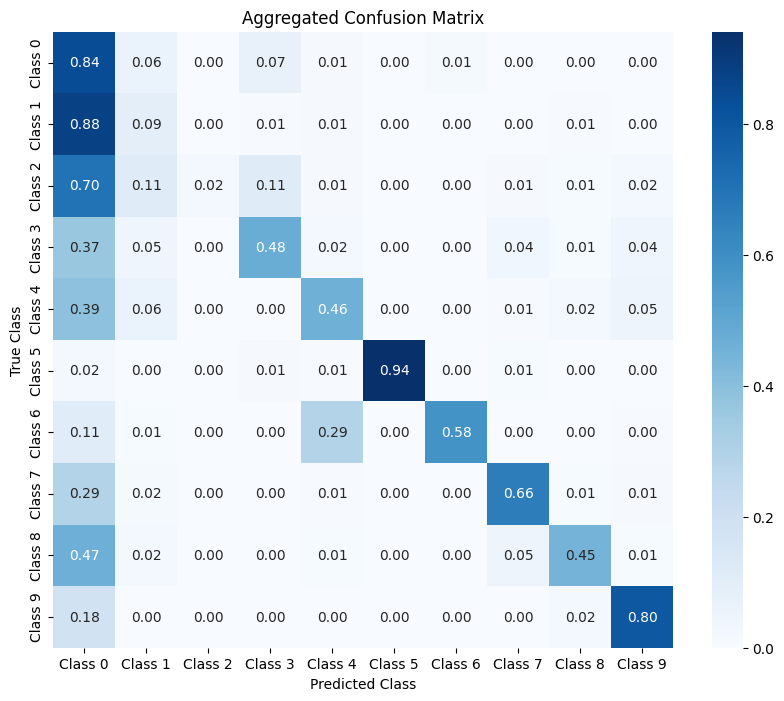

In [20]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Evaluation phase
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Apply threshold (predictions > 0.5 = 1, else 0)
        preds = (outputs > 0.5).int()

        # Append predictions and true labels to lists
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Confusion matrices for all classes
conf_matrices = multilabel_confusion_matrix(all_labels, all_preds)

# Plot each confusion matrix
for i, cm in enumerate(conf_matrices):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Class", f"Class {i}"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for Class {i}')
    plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Flatten the predictions and labels to compute overall metrics
flat_preds = all_preds.ravel()
flat_labels = all_labels.ravel()

# Calculate metrics
accuracy = accuracy_score(flat_labels, flat_preds)
precision = precision_score(flat_labels, flat_preds, average='weighted', zero_division=1)
recall = recall_score(flat_labels, flat_preds, average='weighted', zero_division=1)
f1 = f1_score(flat_labels, flat_preds, average='weighted', zero_division=1)

# Print metrics
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Summarize all predictions and labels across all classes
# True class is a row, predicted class is a column
cm = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))

# Normalize confusion matrix by true labels for better visualization
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[f"Class {i}" for i in range(cm.shape[1])], 
            yticklabels=[f"Class {i}" for i in range(cm.shape[0])])
plt.title("Aggregated Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()
